In [1]:
using Pkg, Revise
Pkg.activate("../GenLinAlgProblems")
using GenLinAlgProblems, LinearAlgebra, RowEchelon, Latexify, SymPy, Random

using PyCall
itikz = pyimport("itikz")
nM    = pyimport("itikz.nicematrix")

Random.seed!(113312);

  Activating project at `C:\Users\Edgar Auger\NOTEBOOKS\elementary-linear-algebra\GenLinAlgProblems`


In [2]:
function ge( matrices, desc, pivot_cols; Nrhs=0, formater=to_latex, pivot_list=nothing, bg_for_entries=nothing,
             variable_colors=["blue","black"], pivot_colors=["blue","yellow!40"],
             ref_path_list=nothing, comment_list=[], variable_summary=nothing, array_names=nothing,
             start_index=1, func=nothing, fig_scale=nothing, tmp_dir="../tmp", keep_file=nothing )

    M = size(matrices[1][end],1)
    N = size(matrices[1][end],2)-Nrhs

    pivot_list, bg_for_entries, ref_path_list, variable_summary = decorate_ge(desc, pivot_cols, (M,N); pivot_color=pivot_colors[2]);

    h,m=nM.ge( formater(matrices), formater=x->x, Nrhs=Nrhs,
               pivot_list       = pivot_list,
               bg_for_entries   = bg_for_entries,
               variable_colors  = variable_colors,pivot_text_color=pivot_colors[1],
               ref_path_list    = ref_path_list, comment_list=comment_list,
               variable_summary = variable_summary,
               array_names      = array_names,
               start_index      = start_index,
               func             = func,
               fig_scale        = fig_scale,
               tmp_dir          = tmp_dir, keep_file=keep_file    )
    h
end
function show_solution( matrices; tmp_dir="../tmp" )
    cascade = nM.BacksubstitutionCascade.from_ref_Ab( Int.(matrices[end][end] ))
    cascade.show( show_system=true, show_cascade=true, show_solution=true, tmp_dir=tmp_dir)
end;

# 1. GE Problems

## 1.1 GE and GJ Problem with Layout

A X = B


L"$\left[
\begin{array}{ccc}
\left[
\begin{array}{cccccc}
1 & -2 & 2 & -2 & 1 & 5 \\
0 & 0 & -1 & 2 & -1 & -2 \\
2 & -4 & 6 & -8 & 4 & 14 \\
\end{array}
\right] & \left[
\begin{array}{cc}
-1 & 1 \\
0 & 0 \\
-1 & 2 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
\end{array}
\right] & \left[
\begin{array}{cc}
-3 & 5 \\
1 & -2 \\
-8 & 14 \\
\end{array}
\right] \\
\end{array}
\right]$"

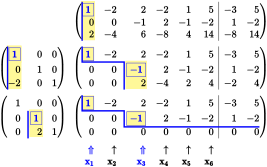

In [3]:
A,X,B = gen_gj_pb(3,6,2; maxint=2, pivot_in_first_col=true, num_rhs=2,has_zeros=false)
matrices, pivot_cols, desc =reduce_to_ref( [A B]; n=size(A,2), gj=false )
println("A X = B")
display(latexify( [A', X', B']' ))

ge( matrices, desc, pivot_cols; Nrhs=2 )

In [4]:
println("pivot cols:  $pivot_cols \n" )

pivot cols:  [1, 3] 



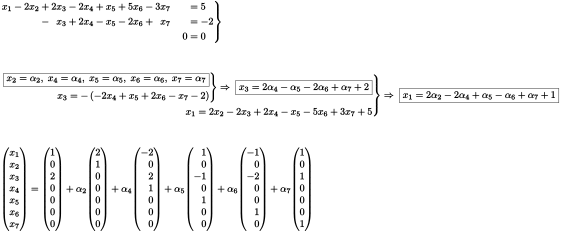

In [5]:
show_solution(matrices)

In [6]:
println()
R,RHS = split_R_RHS( matrices[end][end], size(B,2) )

#println( "Particular Solution, aka X")
#X_p = particular_solution( RB, size(B,2), pivot_cols) 

H = homogeneous_solutions( R, pivot_cols )
println("Homogeneous Solutions: "); latexify(H)


Homogeneous Solutions: 


L"\begin{equation}
\left[
\begin{array}{cccc}
2 & 2 & -1 & -5 \\
1 & 0 & 0 & 0 \\
0 & -2 & 1 & 2 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{array}
\right]
\end{equation}
"

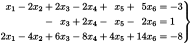

In [7]:
# The following require the RREF problem (i.e., GJ, not GE)
cascade = nM.BacksubstitutionCascade.from_ref_Ab(Int.([R RHS[:,1]]) )
cascade.show(A,B[:,1], show_system=true, show_cascade=false)

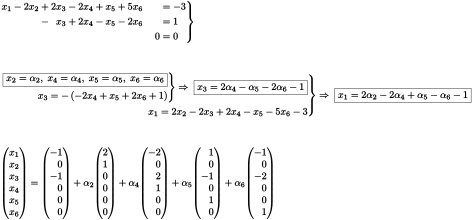

In [8]:
cascade.show( show_system=true, show_cascade=true, show_solution=true)

## 1.2 GE with a Complex Matrix

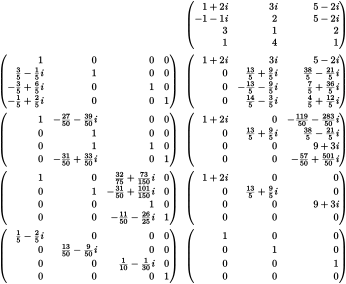

In [62]:
A=[1+2im 3im  5-2im; -1-1im 2 5-2im; 3 1 2; 1 4 1 ]
matrices,pivot_indices,desc = reduce_to_ref(A, gj=true)
h,m=nM.ge(to_latex(matrices), formater=x->x, Nrhs=0, tmp_dir="tmp" )
h

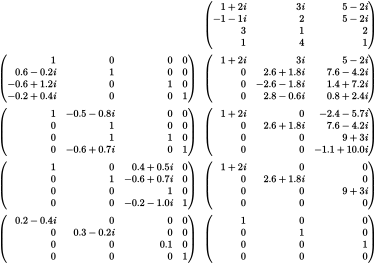

In [63]:
matrices=round_matrices( matrices, 1)
h,m=nM.ge(to_latex(matrices), formater=x->x, Nrhs=0 )
h

## 1.3 Inverse Problem with Layout

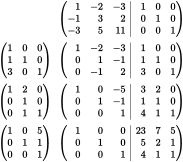

In [9]:
A, A_inv                = gen_inv_pb(3, maxint=3)
matrices, pivot_cols, _ = reduce_to_ref( Rational{Int64}.([A 1I]), gj=true)

h,m=nM.ge( to_latex(matrices), formater=x->x, Nrhs=size(A,1), tmp_dir="tmp" )
h

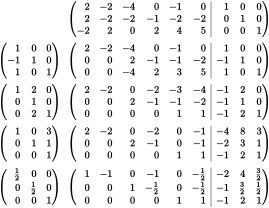

In [10]:
A,_,_ = gen_gj_pb(3,6,3; maxint=2, pivot_in_first_col=true, num_rhs=0,has_zeros=false)

matrices, pivot_cols, _  = reduce_to_ref( Rational{Int64}.([A 1I]), gj=true)

h,m=nM.ge( to_latex(matrices), formater=x->x, Nrhs=size(A,1), tmp_dir="tmp" )
h

In [11]:
println("The first #rank columns of E inverse are the pivot cols of the matrix")
display(latexify(Int64.(inv((matrices[end][end])[:,end-2:end]))))
println("it also contains the switching matrix in its rows:")
display(latexify(Int64.(inv((matrices[end][end])[:,end-2:end]) *matrices[end][end][:,1:6])))
println("We can factor it out of E and obtain C M R")

The first #rank columns of E inverse are the pivot cols of the matrix


L"\begin{equation}
\left[
\begin{array}{ccc}
2 & -4 & -1 \\
2 & -2 & -2 \\
-2 & 0 & 4 \\
\end{array}
\right]
\end{equation}
"

it also contains the switching matrix in its rows:


L"\begin{equation}
\left[
\begin{array}{cccccc}
2 & -2 & -4 & 0 & -1 & 0 \\
2 & -2 & -2 & -1 & -2 & -2 \\
-2 & 2 & 0 & 2 & 4 & 5 \\
\end{array}
\right]
\end{equation}
"

We can factor it out of E and obtain C M R


## 1.3 PLU Problem

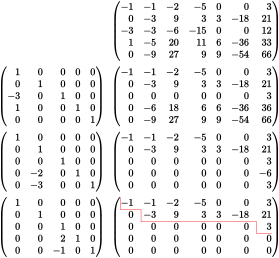

In [12]:
pivot_cols, L,U, A = gen_lu_pb(5,7,3, maxint=3)
matrices,_,_  = reduce_to_ref( A )

pivot_locs    = [(i-1,Int64(pivot_cols[i]-1)) for i in eachindex(pivot_cols)]
ref_path_list = [ [length(matrices)-1, 1, pivot_locs, "vh","red"] ]

h,m = nM.ge(to_latex(matrices), formater=x->x,
            ref_path_list = ref_path_list, tmp_dir="tmp")
h

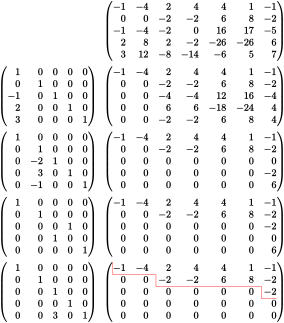

In [13]:
pivot_cols,P,L,U,A=gen_plu_pb(5,7,3)
matrices,_,_  = reduce_to_ref( A )

pivot_locs    = [(i-1,Int64(pivot_cols[i]-1)) for i in eachindex(pivot_cols)]
ref_path_list = [ [length(matrices)-1, 1, pivot_locs, "vh","red"] ]

h,m = nM.ge(to_latex(matrices), formater=x->x,
            ref_path_list = ref_path_list, tmp_dir="tmp")
h

# 2 Normal Equation Problems

<strong style="color:red;">needs work...</strong>

## 2.1 Solve the Normal Equation

In [14]:
A =  gen_full_col_rank_matrix( (1,1,2),3; maxint=2 )
P = ca_projection_matrix( A )
d,Pint = factor_out_denominator( P )
println("Given matrix A = ")
display(latexify(A))
println("The orthogonal projection matrix into the column space of A is given by")
latexify([1//d, Pint']')

Given matrix A = 


L"\begin{equation}
\left[
\begin{array}{ccc}
-2 & 2 & 0 \\
-1 & 0 & 0 \\
0 & -4 & 4 \\
-1 & 4 & -2 \\
\end{array}
\right]
\end{equation}
"

The orthogonal projection matrix into the column space of A is given by


L"\begin{equation}
\left[
\begin{array}{cc}
\frac{1}{13} & \left[
\begin{array}{cccc}
9 & 4 & 2 & 4 \\
4 & 9 & -2 & -4 \\
2 & -2 & 12 & -2 \\
4 & -4 & -2 & 9 \\
\end{array}
\right] \\
\end{array}
\right]
\end{equation}
"

# 3. QR Problems

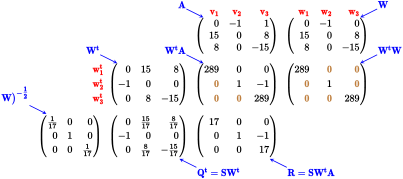

In [15]:
A   = gen_qr_problem_3(maxint=1)
W   = gram_schmidt_w(A)
h,m = nM.gram_schmidt_qr(A, W, tmp_dir="tmp")
h

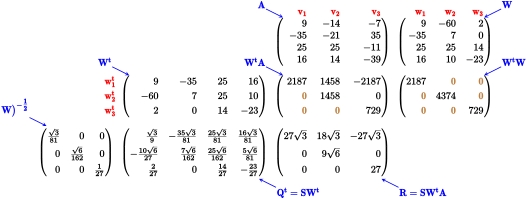

In [16]:
A   = gen_qr_problem_4(maxint=1)[:,shuffle(2:4)]
W   = gram_schmidt_w(A)
h,m = nM.gram_schmidt_qr(A, W, fig_scale=1)
h

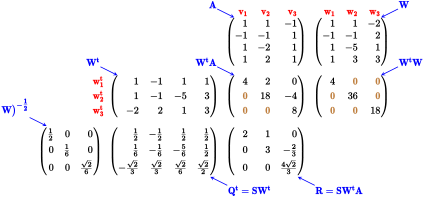

In [17]:
A=[ 1  1 -1
   -1 -1  1
    1 -2  1
    1  2  1
]
W   = gram_schmidt_w(A)
h,m = nM.gram_schmidt_qr(A, W)
h

# 4. Eigenproblems

## 4.1 Eigenproblem for a Square Matrix

L"\begin{equation}
\left[
\begin{array}{ccc}
7 & -2 & 1 \\
0 & 1 & 0 \\
-30 & 10 & -4 \\
\end{array}
\right]
\end{equation}
"

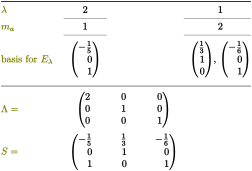

In [18]:
S,Λ,Sinv,A=gen_eigenproblem([1,1,2])
display(latexify(A))
nM.show_eig_tbl(A,fig_scale=1, mmLambda=11, color="Olive" )

## 4.2 Eigenproblem for a Symmetrix Matrix

L"\begin{equation}
\left[
\begin{array}{cc}
\frac{1}{25} & \left[
\begin{array}{cccc}
32 & 0 & 24 & 0 \\
0 & 75 & 0 & 0 \\
24 & 0 & 18 & 0 \\
0 & 0 & 0 & 50 \\
\end{array}
\right] \\
\end{array}
\right]
\end{equation}
"

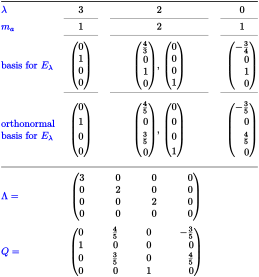

In [19]:
S,Λ,A=gen_symmetric_eigenproblem([2,2,3,0], maxint=2)

d,A_=factor_out_denominator(A)
display(latexify([1//d,A_']'))
nM.show_eig_tbl(A_,Ascale=d,normal=true, fig_scale=1, mmLambda=11, color="blue" )

L"\begin{equation}
\left[
\begin{array}{c}
\left[
\begin{array}{ccc}
125 & 33 & -8 \\
-369 & -97 & 24 \\
399 & 107 & -24 \\
\end{array}
\right] \\
\left[
\begin{array}{ccc}
1 & 0 & \frac{-1}{3} \\
0 & 1 & 1 \\
0 & 0 & 0 \\
\end{array}
\right] \\
\end{array}
\right]
\end{equation}
"

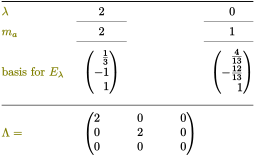

In [20]:
A=Rational{Int64}.(gen_non_diagonalizable_eigenproblem(2,0))
display(latexify([ A, rref(A-2I)] ))
nM.show_eig_tbl(Int.(A),fig_scale=1.2, mmLambda=11, color="Olive", tmp_dir="tmp" )

## 4.3 SVD

"\\begin{equation}\n\\left[\n\\begin{array}{ccccc}\n\\frac{1}{175} & \\left[\n\\begin{array}{ccccc}\n-80 & -168 & -120 & 126 & -240 \\\\\n-60 & 224 & -90 & -168 & -180 \\\\\n0 & 0 & 0 & 0 & 0 \\\\\n\\end{array}\n\\right] & \\left[\n\\begin{array}{ccc}\n\\frac{-4}{5} & \\frac{3}{5} & 0 \\\\\n\\frac{-3}{5}" ⋯ 226 bytes ⋯ "{7} & 0 & \\frac{6}{7} \\\\\n0 & \\frac{-4}{5} & 0 & \\frac{3}{5} & 0 \\\\\n0 & \\frac{3}{5} & 0 & \\frac{4}{5} & 0 \\\\\n\\frac{3}{7} & 0 & \\frac{-6}{7} & 0 & \\frac{2}{7} \\\\\n\\frac{6}{7} & 0 & \\frac{2}{7} & 0 & \\frac{-3}{7} \\\\\n\\end{array}\n\\right] \\\\\n\\end{array}\n\\right]\n\\end{equation}\n"

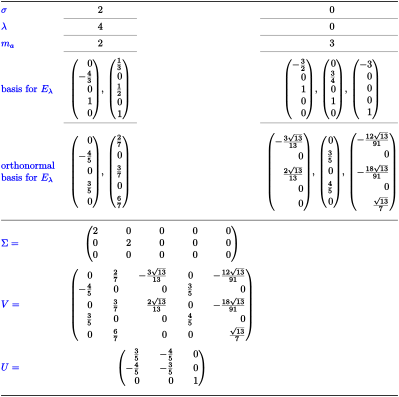

In [21]:
U,Σ,Vt,A = gen_svd_problem(3,[3,2],  [2,2],  maxint=2)

d,intA=factor_out_denominator(A)
display( latexify([1//d,intA',U',Σ',Vt']'))
nM.show_svd_table(intA, Ascale=d, mmS=7, mmLambda=10, tmp_dir="tmp")

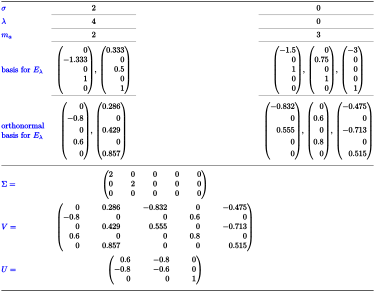

In [22]:
nM.show_svd_table(intA, Ascale=d, eig_digits=0, sigma_digits=0, vec_digits=3, fig_scale=0.8)

Note that if we work with real numbers, numerical errors yield a result looking quite different:<br>$\qquad$
the algebraic multiplicities are different due to roundoff.

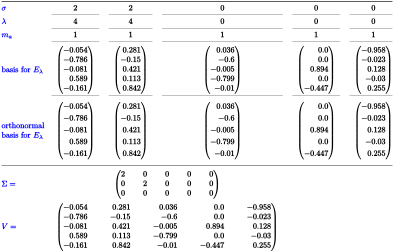

In [23]:
nM.show_svd_table(A, Ascale=1.0, eig_digits=0, sigma_digits=0, vec_digits=3, fig_scale=0.8)

In [24]:
table=nM.svd_tbl(A)
table.eig

Dict{Any, Any} with 6 entries:
  "sigma"  => Sym[1.99999999999999998948294436794689458867539665206409874213838…
  "evecs"  => SymMatrix[SymMatrix(PyObject Matrix([…
  "uvecs"  => Any[SymMatrix(PyObject Matrix([…
  "qvecs"  => SymMatrix[SymMatrix(PyObject Matrix([…
  "ma"     => [1, 1, 1, 1, 1]
  "lambda" => Sym[3.99999999999999995793177747178757846531004577595633952307853…

In [25]:
#A=svd_problem(4,[2,3],[2,1,1])
sol=svd(intA)
display("U =");display(round.(sol.U, digits=3))
display("singular values =");display(round.(sol.S, digits=3))
display("Vt =");display(round.(sol.Vt, digits=3))

"U ="

3×3 Matrix{Float64}:
 -0.707  -0.707  0.0
  0.707  -0.707  0.0
  0.0     0.0    1.0

"singular values ="

3-element Vector{Float64}:
 350.0
 350.0
   0.0

"Vt ="

3×5 Matrix{Float64}:
  0.04    0.792  0.061  -0.594   0.121
  0.283  -0.113  0.424   0.085   0.849
 -0.423   0.044  0.856   0.059  -0.287

# Quick Tests

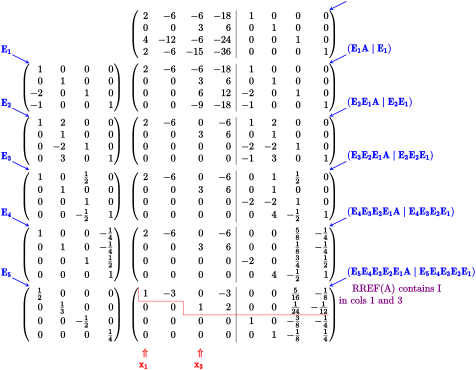

In [28]:
A = [
 2   -6   -6  -18
 0    0    3    6
 4  -12   -6  -24
 2   -6  -15  -36]
matrices, pivot_indices,_ = reduce_to_ref(Rational{Int64}.([A I]), gj=true)
pivot_locs = [(i-1,Int64(pivot_indices[i]-1)) for i in eachindex(pivot_indices[1:2])]

h,m = nM.ge(to_latex(matrices), formater=x->x, Nrhs=size(A,1), tmp_dir="tmp",
           ref_path_list =  [ [length(matrices)-1, 1, pivot_locs, "vh","red"] ],
           comment_list=["","", "", "", "", raw"""RREF(A)  contains I\\
                                                  \ \     in cols 1 and 3"""],
           array_names = [ "E", ["A", "I"]],
           variable_summary = [true, :none, true, :none]
)
h

In [29]:
S= [1 0 0; 0 1  0; 1 1 1]
Sinv = Int.(round.(inv(S)))
A = S * diagm( [2, 1, 0]) * Sinv

3×3 Matrix{Int64}:
 2  0  0
 0  1  0
 2  1  0

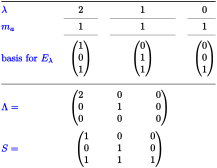

In [30]:
d,intA=factor_out_denominator(A)
nM.show_eig_tbl(intA, Ascale=d, mmLambda=12)

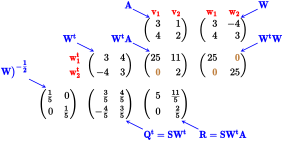

In [31]:
A=[ 3 1; 4 2]
W   = gram_schmidt_w(A)
h,m = nM.gram_schmidt_qr(A, W)
h

In [32]:
A=[ 3 0 0 0; 0 3 0 0; 0 0 3 3; 0 0 3 3]
eigen(A)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
4-element Vector{Float64}:
 3.552713678800501e-15
 3.0
 3.0
 6.0
vectors:
4×4 Matrix{Float64}:
  0.0       0.0  1.0  0.0
  0.0       1.0  0.0  0.0
  0.707107  0.0  0.0  0.707107
 -0.707107  0.0  0.0  0.707107

# Live Demos

Reverting Windows console CPs to (in,out) = (437,437)


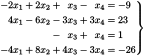

In [55]:
M = 4; N = 4; r = 4; Nrhs=1; gj=false
# ======================================================================================
A,X,B = gen_gj_pb(M,N,r; maxint=2, pivot_in_first_col=true, num_rhs=Nrhs,has_zeros=false)

# ------- display the system
foo=nM.BacksubstitutionCascade( Int.(A), Int.(B))
display(foo.show( show_system=true, show_cascade=false, show_solution=false, tmp_dir="../tmp"))

In [56]:
println("Matrix form:  A X = B")

display(latexify( [A', X', B']' ))

A X = B


L"\begin{equation}
\left[
\begin{array}{ccc}
\left[
\begin{array}{cccc}
-2 & 2 & 1 & -1 \\
4 & -6 & -3 & 3 \\
0 & 0 & -1 & 1 \\
-4 & 8 & 4 & -3 \\
\end{array}
\right] & \left[
\begin{array}{c}
2 \\
-2 \\
1 \\
2 \\
\end{array}
\right] & \left[
\begin{array}{c}
-9 \\
23 \\
1 \\
-26 \\
\end{array}
\right] \\
\end{array}
\right]
\end{equation}
"

Reverting Windows console CPs to (in,out) = (437,437)


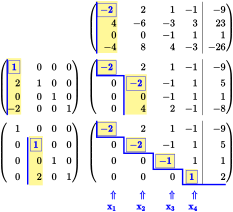

In [57]:
# Gaussian Elimination algorithm

matrices, pivot_cols, desc = reduce_to_ref( [A B]; n=N, gj=gj );
ge( matrices, desc, pivot_cols; Nrhs=Nrhs )

Reverting Windows console CPs to (in,out) = (437,437)


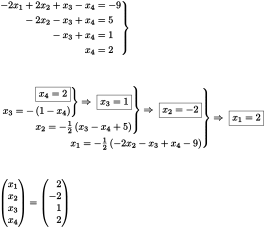

In [58]:
# Backsubstitution
show_solution(matrices)